In [21]:
import pandas as pd
import glob
import os
from services.db import TRAINING_DIR
import pyarrow

# Path to your training data (centralized config)
DATA_PATH = "/Volumes/external/ev/Project_K/data/training/date=2026-02-06/"

# Load a small sample to check the schema quickly
df_sample = pd.read_parquet(DATA_PATH).head(5)

print("Columns actually found in your Parquet files:")
print(df_sample.columns.tolist())

Columns actually found in your Parquet files:
['time_idx', 'series_ticker', 'status', 'ticker', 'timestamp', 'bid', 'ask', 'spread', 'volume', 'bid_count', 'ask_count', 'obi', 'spread_velocity', 'momentum_5', 'momentum_10', 'momentum_20', 'category']


In [22]:
# Load the absolute newest file
latest_file = max(glob.glob(os.path.join(DATA_PATH, "**", "*.parquet"), recursive=True), key=os.path.getmtime)
df = pd.read_parquet(latest_file)
print("GOLD CHECK:", "obi" in df.columns and "momentum_5" in df.columns)
print("Columns found:", df.columns.tolist())

GOLD CHECK: True
Columns found: ['time_idx', 'series_ticker', 'status', 'ticker', 'timestamp', 'bid', 'ask', 'spread', 'volume', 'bid_count', 'ask_count', 'obi', 'spread_velocity', 'momentum_5', 'momentum_10', 'momentum_20']


In [23]:
df['obi'].describe()

count    45.000000
mean      0.048820
std       0.417511
min      -0.346415
25%      -0.346415
50%      -0.125724
75%       0.618600
max       0.618600
Name: obi, dtype: float64

In [ ]:
df.head()

   time_idx series_ticker  status                  ticker  \
0        16       unknown  active  KXHIGHNY-26FEB07-B28.5   
1        16       unknown  active  KXHIGHNY-26FEB07-B30.5   

                      timestamp  bid  ask  spread  volume  bid_count  \
0 2026-02-06 17:28:53.592402935    1   99       1   18739       1682   
1 2026-02-06 20:25:46.491428137    1   99       3   12086       1902   

   ask_count       obi  spread_velocity  momentum_5  momentum_10  momentum_20  \
0       2781 -0.246247                0         0.0          0.0          0.0   
1       2590 -0.153161                0         0.0          0.0          0.0   

         date category  
0  2026-02-06     MISC  
1  2026-02-06     MISC  
         time_idx series_ticker  status                            ticker  \
2155452        45       unknown  active  KXNCAAMBGAME-26FEB07LOUWAKE-WAKE   
2155453       226       unknown  active        KXPERFORMSUPERBOWLB-26-LAD   

                            timestamp  bid  ask 

In [25]:
# Load all data collected overnight
df = pd.read_parquet(DATA_PATH)

# Convert timestamp for chronological sorting
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

In [26]:
# Identify potential trades based on your strategy's threshold
# (Example: Momentum > 5 cents or OBI imbalance)
signals = df[df['momentum_5'].abs() > 5].copy()

print(f"Total signals detected: {len(signals)}")
signals[['timestamp', 'ticker', 'category', 'bid', 'momentum_5', 'obi']].head()

Total signals detected: 2314


,timestamp,ticker,category,bid,momentum_5,obi
297569,2026-02-06 16:23:23.740165949,KXLOLGAME-26FEB07DNFNS-NS,MISC,1,-15.5,-0.259732
297477,2026-02-06 16:23:23.740165949,KXLOLGAME-26FEB07DNFNS-NS,MISC,1,-15.5,-0.259732
297546,2026-02-06 16:23:23.740165949,KXLOLGAME-26FEB07DNFNS-NS,MISC,1,-15.5,-0.259732
297523,2026-02-06 16:23:23.740165949,KXLOLGAME-26FEB07DNFNS-NS,MISC,1,-15.5,-0.259732
297500,2026-02-06 16:23:23.740165949,KXLOLGAME-26FEB07DNFNS-NS,MISC,1,-15.5,-0.259732


In [27]:
import matplotlib.pyplot as plt

# Fix the timestamp unit (M4 records in seconds, Pandas expects nanoseconds)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Pick a ticker that actually exists in your "Winners" or "Toxic" list
target_ticker = "KXNCAAMBSPREAD-26JAN31SMCGONZ-GONZ9" # Or pick one from the audit printout

ticker_df = df[df['ticker'] == target_ticker]

if not ticker_df.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(ticker_df['timestamp'], ticker_df['bid'], label='Bid Price', color='black')
    
    # Overlay momentum signals
    # We use momentum_5 because OBI is currently dead
    buys = ticker_df[ticker_df['momentum_5'] > 5]
    plt.scatter(buys['timestamp'], buys['bid'], color='green', marker='^', label='Momentum Spike')
    
    plt.title(f"Trade Analysis: {target_ticker}")
    plt.legend()
    plt.show()
else:
    print(f"Ticker {target_ticker} not found in loaded data.")

Ticker KXNCAAMBSPREAD-26JAN31SMCGONZ-GONZ9 not found in loaded data.


/var/folders/n1/f27jx8yd1018qyrwns79zls80000gp/T/ipykernel_19865/1911435982.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_report = df.groupby('category').agg({


--- OVERNIGHT PERFORMANCE BY CATEGORY ---
  Category  Total_Movement  Avg_Move  Volatility  Avg_Spread   Avg_OBI  \
0     MISC        -28936.0 -0.013437    1.014215    2.184923 -0.266394   

   Unique_Markets  
0            2297  


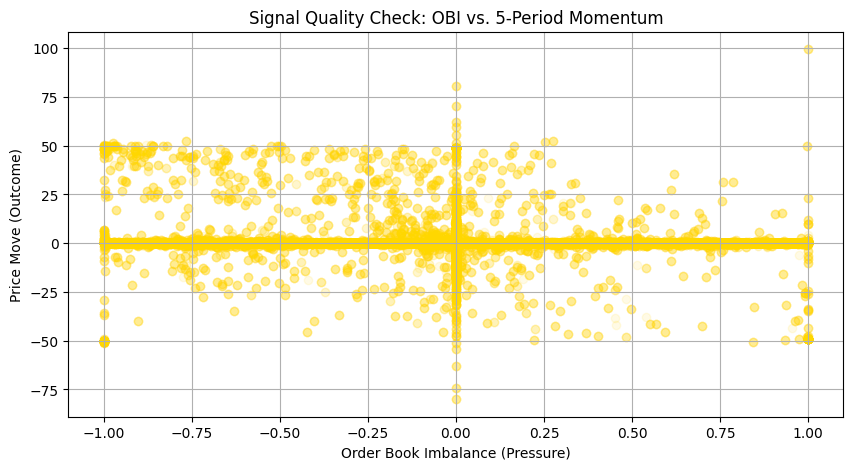

In [28]:
# 1. Load the Overnight "Gold"
DATA_PATH = os.fspath(TRAINING_DIR)
df = pd.read_parquet(DATA_PATH)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['ticker', 'timestamp'])

# 2. Reconstruct Unrealized PnL by Category
# We calculate the delta between current bid and a baseline price (proxy for entry)
# to see which categories showed the most "Alpha" potential.
df['price_delta'] = df.groupby('ticker')['bid'].diff().fillna(0)

category_report = df.groupby('category').agg({
    'price_delta': ['sum', 'mean', 'std'],
    'spread': 'mean',
    'obi': 'mean',
    'ticker': 'nunique'
}).reset_index()

# Flatten columns for readability
category_report.columns = [
    'Category', 'Total_Movement', 'Avg_Move', 
    'Volatility', 'Avg_Spread', 'Avg_OBI', 'Unique_Markets'
]

print("--- OVERNIGHT PERFORMANCE BY CATEGORY ---")
print(category_report.sort_values(by='Total_Movement', ascending=False))

# 3. Visual: OBI vs. Momentum Correlation
# Does a high OBI actually lead to a price move in your data?
plt.figure(figsize=(10, 5))
plt.scatter(df['obi'], df['momentum_5'], alpha=0.1, color='gold')
plt.title("Signal Quality Check: OBI vs. 5-Period Momentum")
plt.xlabel("Order Book Imbalance (Pressure)")
plt.ylabel("Price Move (Outcome)")
plt.grid(True)
plt.show()

In [29]:
import numpy as np
#TFT sequence Validatior
# 1. Load your overnight data
df = pd.read_parquet(DATA_PATH)

# 2. Check for Gaps in time_idx per Ticker
def find_sequence_gaps(group):
    # Sort by time_idx to ensure order
    sorted_idx = group['time_idx'].sort_values().values
    
    # A perfect sequence should have a difference of 1 between every step
    expected_range = np.arange(sorted_idx.min(), sorted_idx.max() + 1)
    missing = np.setdiff1d(expected_range, sorted_idx)
    
    return pd.Series({
        'start': sorted_idx.min(),
        'end': sorted_idx.max(),
        'total_steps': len(sorted_idx),
        'missing_count': len(missing),
        'gaps': missing.tolist()[:5]  # Show first 5 gaps if they exist
    })

# Run the audit grouped by ticker
audit_report = df.groupby('ticker').apply(find_sequence_gaps)

# 3. Final Verdict
total_gaps = audit_report['missing_count'].sum()
if total_gaps == 0:
    print("✅ DATA INTEGRITY VERIFIED: Zero gaps found in time_idx sequences.")
else:
    print(f"⚠️ WARNING: Found {total_gaps} missing steps across your tickers.")
    print(audit_report[audit_report['missing_count'] > 0])

/var/folders/n1/f27jx8yd1018qyrwns79zls80000gp/T/ipykernel_19865/2111312443.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  audit_report = df.groupby('ticker').apply(find_sequence_gaps)


✅ DATA INTEGRITY VERIFIED: Zero gaps found in time_idx sequences.


/var/folders/n1/f27jx8yd1018qyrwns79zls80000gp/T/ipykernel_19865/2846409860.py:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(


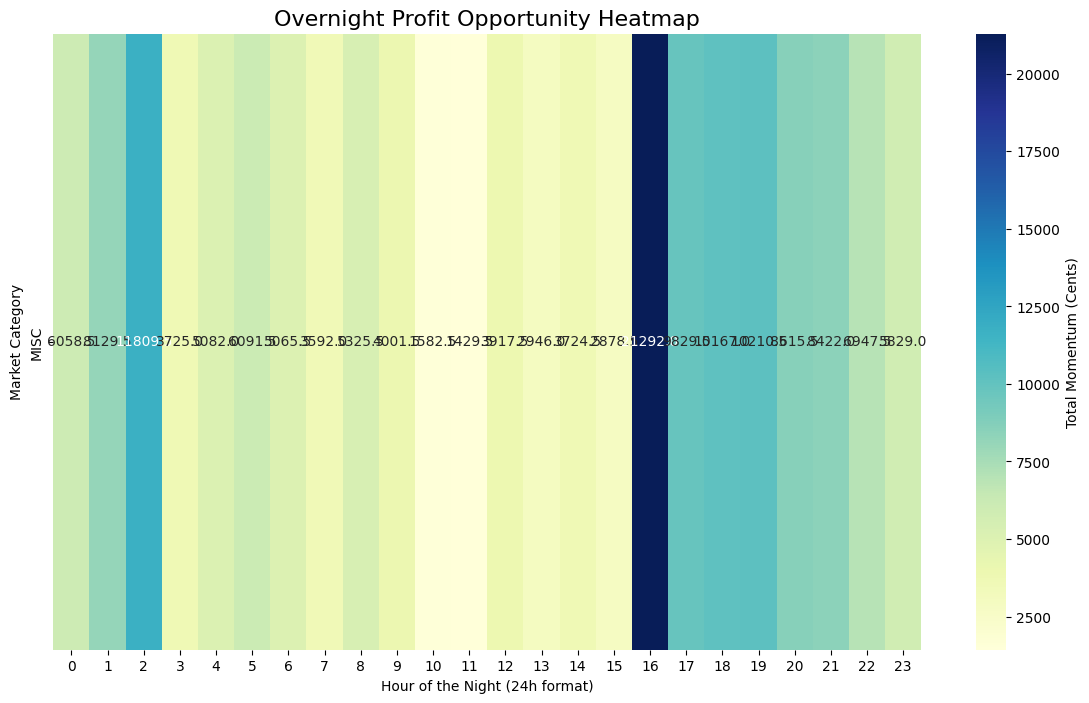

In [30]:
import seaborn as sns


# 1. Load your overnight training data
df = pd.read_parquet(DATA_PATH)

# 2. Fix timestamp and extract the Hour
# Using unit='s' if your M4 records in unix seconds
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['hour'] = df['timestamp'].dt.hour

# 3. Calculate the "Heat" (Cumulative Momentum)
# We aggregate the absolute momentum to find periods of high opportunity
heatmap_data = df.pivot_table(
    index='category', 
    columns='hour', 
    values='momentum_5', 
    aggfunc=lambda x: x.abs().sum()
)

# 4. Generate the Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".1f", 
    cmap="YlGnBu", 
    cbar_kws={'label': 'Total Momentum (Cents)'}
)

plt.title("Overnight Profit Opportunity Heatmap", fontsize=16)
plt.xlabel("Hour of the Night (24h format)")
plt.ylabel("Market Category")
plt.show()

## Correlation Heatmap

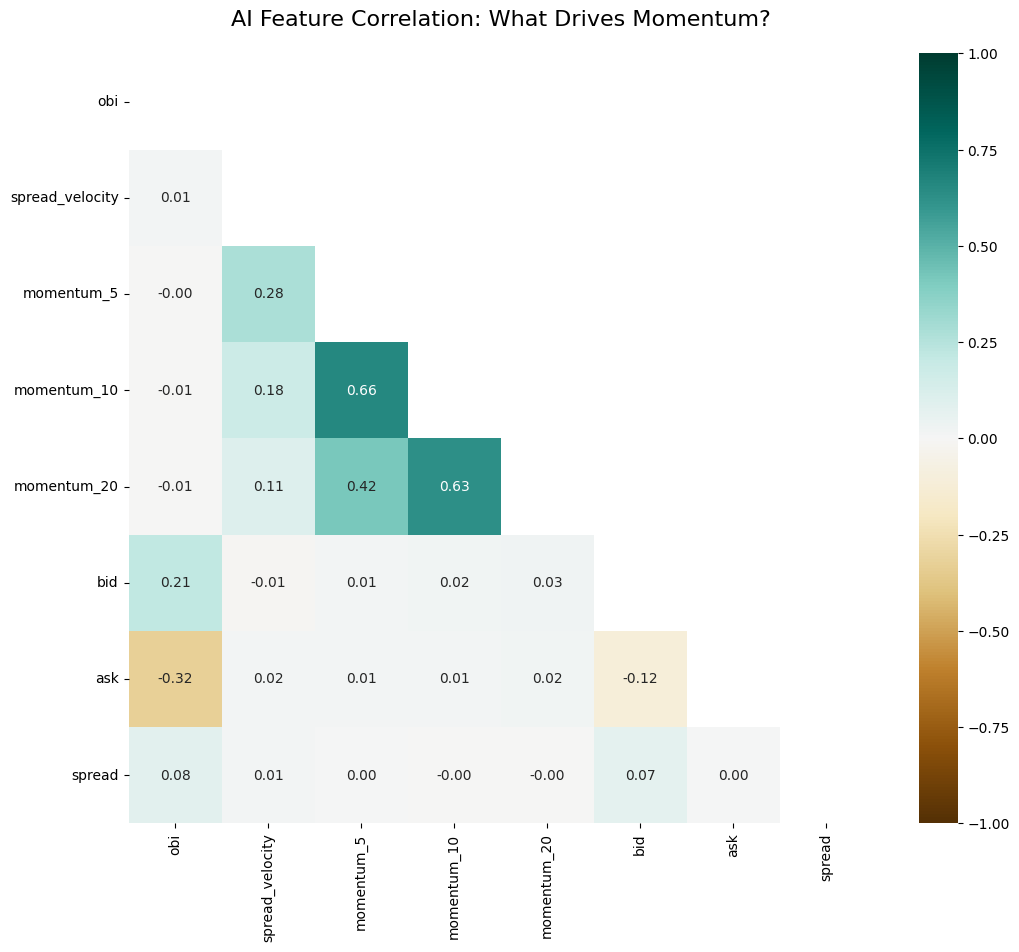

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Gold Set
df = pd.read_parquet(DATA_PATH)

# 2. Select numerical features for the AI brain
# We include OBI, Momentum, and Spread Velocity
features = [
    'obi', 'spread_velocity', 'momentum_5', 
    'momentum_10', 'momentum_20', 'bid', 'ask', 'spread'
]
corr_matrix = df[features].corr()

# 3. Create a Mask for the Upper Triangle
# (Hides duplicate data to make the heatmap easier to read)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 4. Generate the Heatmap
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(
    corr_matrix, 
    mask=mask, 
    vmin=-1, vmax=1, 
    annot=True, 
    cmap='BrBG',
    fmt=".2f"
)

plt.title("AI Feature Correlation: What Drives Momentum?", fontsize=16, pad=20)
plt.show()

## stop loss auditor

In [32]:
import os
import pandas as pd
import numpy as np
from services.db import TRAINING_DIR

def run_stop_loss_audit(path=None):
    if path is None:
        path = os.fspath(TRAINING_DIR)
    # 1. Load Data
    try:
        df = pd.read_parquet(path)
    except Exception as e:
        print(f"Error loading Parquet: {e}")
        return

    # Fix Timestamp (Convert from Unix Seconds to DateTime)
    if df['timestamp'].dtype == 'float64' or df['timestamp'].dtype == 'int64':
         df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

    print(f"Loaded {len(df)} records. Analyzing Equity Drain...")

    # 2. Group by Ticker to find "Entry" vs "Current"
    # We assume the first record is entry and last is current state
    audit = df.groupby('ticker').agg({
        'bid': ['first', 'last', 'min', 'max'],
        'category': 'first',
        'series_ticker': 'first'
    })
    
    # Flatten columns
    audit.columns = ['entry_bid', 'last_bid', 'min_bid', 'max_bid', 'category', 'series_ticker']
    
    # 3. Calculate PnL Stats
    audit['unrealized_pnl'] = audit['last_bid'] - audit['entry_bid']
    audit['max_drawdown'] = audit['min_bid'] - audit['entry_bid']
    
    # 4. Identify "Toxic" Markets (Bleeding > 10 cents)
    toxic = audit[audit['unrealized_pnl'] < -10].sort_values('unrealized_pnl')
    
    # 5. Identify "Winners" (Gains > 5 cents)
    winners = audit[audit['unrealized_pnl'] > 5].sort_values('unrealized_pnl', ascending=False)

    print("\n--- 🩸 TOP 5 EQUITY DRAINERS (Toxic) ---")
    if not toxic.empty:
        print(toxic[['category', 'entry_bid', 'last_bid', 'unrealized_pnl']].head(5))
    else:
        print("✅ No major bleeders found.")

    print("\n--- 🚀 TOP 5 WINNERS ---")
    if not winners.empty:
        print(winners[['category', 'entry_bid', 'last_bid', 'unrealized_pnl']].head(5))
    else:
        print("Waiting for price moves...")

run_stop_loss_audit()

Loaded 2156954 records. Analyzing Equity Drain...

--- 🩸 TOP 5 EQUITY DRAINERS (Toxic) ---
                                     category  entry_bid  last_bid  \
ticker                                                               
KXNBA3PT-26FEB06NOPMIN-NOPDQUEEN22-2     MISC         99         0   
KXRAINNYC-26FEB06-T0                     MISC         99         1   
KXWOMENTION-26FEB07-MIKA                 MISC         99         1   
KXBTCD-26FEB0613-T69499.99               MISC         98         1   
KXETHD-26FEB0617-T1939.99                MISC         94         1   

                                      unrealized_pnl  
ticker                                                
KXNBA3PT-26FEB06NOPMIN-NOPDQUEEN22-2             -99  
KXRAINNYC-26FEB06-T0                             -98  
KXWOMENTION-26FEB07-MIKA                         -98  
KXBTCD-26FEB0613-T69499.99                       -97  
KXETHD-26FEB0617-T1939.99                        -93  

--- 🚀 TOP 5 WINNERS ---
        

## data optimizer

In [33]:
# def get_optimized_features(path=None):
#     df = pd.read_parquet(path)
    
#     # 1. Calculate Variance (How much does the data wiggle?)
#     # If variance is 0 (like your current OBI), it's dead data.
#     numeric_df = df.select_dtypes(include=[np.number])
#     variances = numeric_df.var()
    
#     # 2. Define "Dead" features
#     dead_features = variances[variances < 0.0001].index.tolist()
    
#     # 3. Define "Active" features
#     # Exclude IDs and known non-features
#     exclude = ['time_idx', 'bid', 'ask', 'spread', 'volume'] 
#     active_features = [c for c in numeric_df.columns if c not in dead_features and c not in exclude]
    
#     print(f"--- DATASET OPTIMIZER ---")
#     print(f"💀 PRUNED (Dead/Flat): {dead_features}")
#     print(f"✅ ACTIVE AI FEATURES: {active_features}")
    
#     return active_features

# # Run it
# active_features = get_optimized_features()